In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# Load the dataset
file_path = 'CleanElementry.csv'
df_new = pd.read_csv(file_path)

# Display the first few rows of the dataset to confirm successful loading
df_new.head() 


,School,Teacher_Score,Pre_RI_Competence,Pre_RI_Interest,Pre_RI_Self_Recognition,Pre_RI_Recognition_ByOthers,Post_RI_Competence,Post_RI_Interest,Post_RI_Self_Recognition,Post_RI_Recognition_ByOthers,Pre_Final,Post_Final,Class_Pre_Interest,Class_Post_Interest
0,13.940476,85,11,13,12,16,9,14,12,14,5,15,B,B
1,13.940476,85,13,15,15,12,13,17,15,14,12,15,B,A
2,13.940476,85,14,14,12,12,12,15,11,15,14,16,B,B
3,13.940476,85,17,18,18,18,15,13,18,18,12,15,A,B
4,13.940476,85,10,11,15,14,8,12,7,6,13,16,B,B


In [7]:
# Encode categorical variables
from sklearn.calibration import LabelEncoder


encoder = LabelEncoder()
df_new['Class_Pre_Interest'] = encoder.fit_transform(df_new['Class_Pre_Interest'])
df_new['Class_Post_Interest'] = encoder.fit_transform(df_new['Class_Post_Interest'])

# Define feature matrix (X) and target vector (y)
X_new = df_new[['Class_Pre_Interest', 'Post_RI_Competence', 'Pre_RI_Competence', 
                'Post_Final', 'Pre_Final', 'Pre_RI_Self_Recognition', 
                'Post_RI_Self_Recognition', 'Pre_RI_Recognition_ByOthers', 
                'Post_RI_Recognition_ByOthers', 'Teacher_Score', 'School']]
y_new = df_new['Class_Post_Interest']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((312, 11), (79, 11), (312,), (79,))

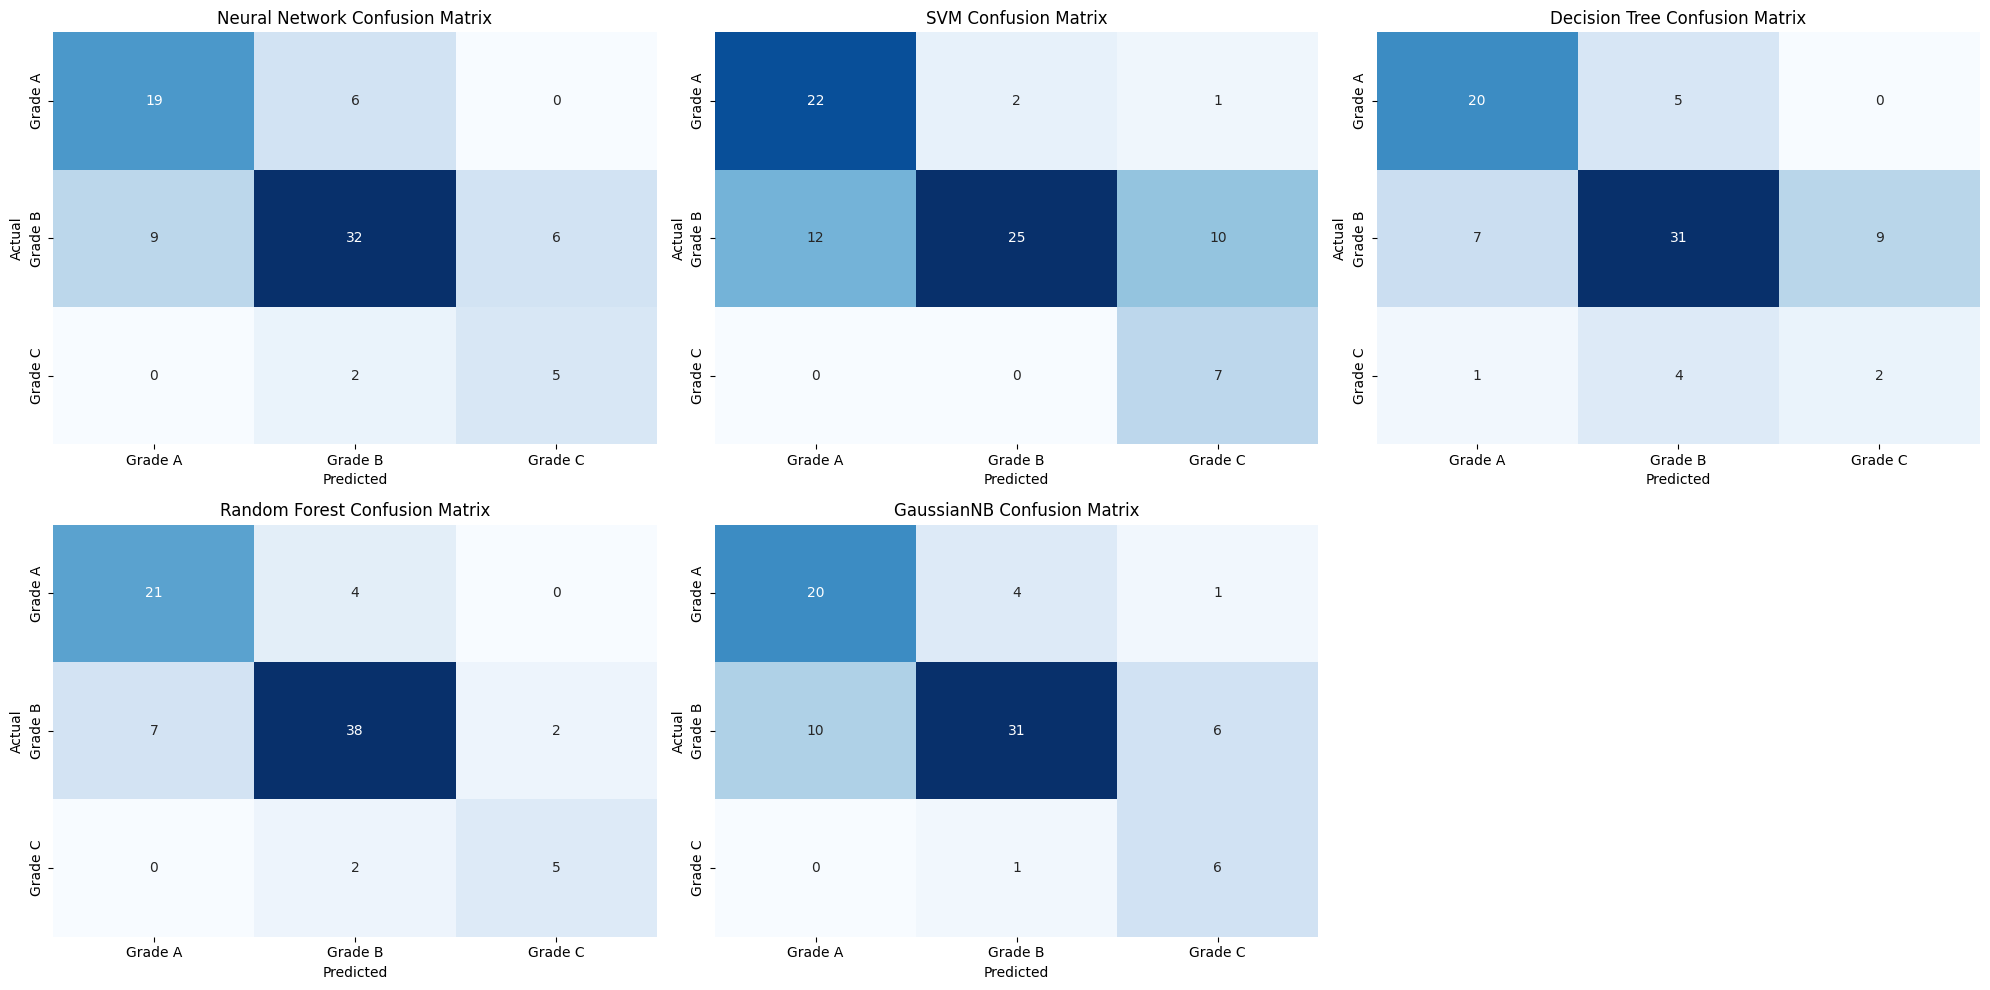

In [8]:
# Calculate class weights for handling class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Reinitialize models with appropriate adjustments
models_adjusted = {
    "Neural Network": MLPClassifier(max_iter=10000, random_state=42),
    "SVM": SVC(class_weight='balanced', random_state=42),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "GaussianNB": GaussianNB()
}

# Re-train the models and evaluate them
confusion_matrices_adjusted = {}
classification_reports_adjusted = {}

for name, model in models_adjusted.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Compute confusion matrix and classification report
    confusion_matrices_adjusted[name] = confusion_matrix(y_test, y_pred)
    classification_reports_adjusted[name] = classification_report(y_test, y_pred, zero_division=0)

# Display the updated confusion matrices and classification reports
confusion_matrices_adjusted, classification_reports_adjusted

# Plot confusion matrices
plt.figure(figsize=(20, 10))
for i, (name, matrix) in enumerate(confusion_matrices_adjusted.items(), 1):
    plt.subplot(2, 3, i)
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=['Grade A', 'Grade B', 'Grade C'],
                yticklabels=['Grade A', 'Grade B', 'Grade C'])
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

plt.tight_layout()
plt.show()

In [9]:
# Print the classification reports for all models
for model, report in classification_reports_adjusted.items():
    print(f"Classification Report for {model}:\n")
    print(report)
    print("=" * 80)

Classification Report for Neural Network:

              precision    recall  f1-score   support

           0       0.68      0.76      0.72        25
           1       0.80      0.68      0.74        47
           2       0.45      0.71      0.56         7

    accuracy                           0.71        79
   macro avg       0.64      0.72      0.67        79
weighted avg       0.73      0.71      0.71        79

Classification Report for SVM:

              precision    recall  f1-score   support

           0       0.65      0.88      0.75        25
           1       0.93      0.53      0.68        47
           2       0.39      1.00      0.56         7

    accuracy                           0.68        79
   macro avg       0.65      0.80      0.66        79
weighted avg       0.79      0.68      0.69        79

Classification Report for Decision Tree:

              precision    recall  f1-score   support

           0       0.71      0.80      0.75        25
           1

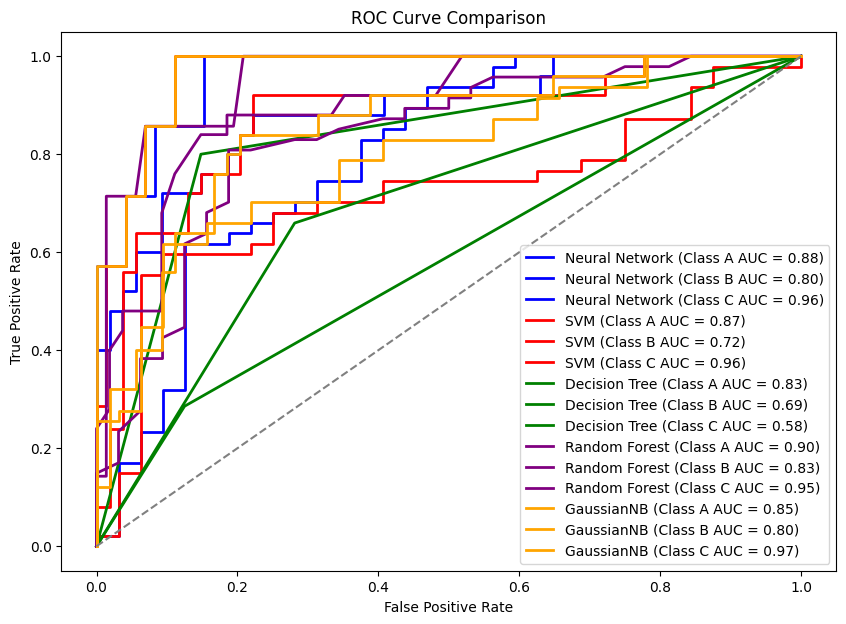

In [13]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the output labels for multi-class ROC-AUC
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_binarized.shape[1]

# Colors for plotting
colors = cycle(["blue", "red", "green", "purple", "orange"])

# Plot ROC Curve for each classifier
plt.figure(figsize=(10, 7))

for (name, model), color in zip(models_adjusted.items(), colors):
    # Predict probabilities if supported; otherwise, use decision function
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
    else:
        y_score = model.decision_function(X_test)
    
    # Compute ROC curve and AUC for each class
    class_labels = {0: 'A', 1: 'B', 2: 'C'}

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=color, lw=2, label=f"{name} (Class {class_labels[i]} AUC = {roc_auc:.2f})")

# Plot the diagonal reference line
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")

# Labeling the plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.show()